In [1]:
import pandas as pd

In [36]:
def read_excel(excel_path, tab):
    df = pd.read_excel(excel_path, tab)
    df.index = pd.to_datetime(df['DATETIME'])
    del df['DATETIME']
    return df

def drown_factor(h1, h2, m, flow=0, vortex=False):
    #https://help.autodesk.com/view/IWICMS/2024/ENU/?guid=GUID-66F0B502-4BE9-428A-A2CD-D43047B2093C
    """h1: head (upstream depth if m>0, otherwise h1=us - ds depth
    h2: downstream depth
    m: modular limit


    Args:
        h1 (_type_): _description_
        h2 (_type_): _description_
        m (_type_): _description_
        flow (int, optional): _description_. Defaults to 0.
        vortex (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if m==0: return 1 # m=0, it will not use modular limit
    # swithc h1, h2 if it is reverse flow and not a vortex
    if flow < 0 and (not vortex): h1, h2 = h2, h1
    # in case it will give div by zero error
    if h1 == 0: return 1
    # if it is not drowned
    if h2/h1 <= m: return 1
    f = ((1 - h2 / h1) / (1 - m))**0.5
    # print(f)
    if f < 0.3:
         f = (1 - h2 / h1) / (0.3 * (1 - m))
    return f


In [29]:
def verify_user_control(invert, rc_name, df, m, use_diff=False):
    """Calculates and plots various parameters based on invert, rc_name, and a dataframe.

    Args:
        invert (int): Value of invert.
        rc_name (str): Name of the rating column ('rating' is used as example).
        df (pd.DataFrame): Dataframe containing relevant data. 
        m (float): modular limit

    Returns:
        pd.DataFrame: DataFrame with calculated parameters and flow rate based on drown factor. 
    """

    # Calculate US head, depth, and difference
    df = df.copy()
    df['h1'] = df['US depth (m)']
    df['h2'] = df['DS depth (m)'] 
    df['h_diff'] = df['h1'] - df['h2']
    df['flow'] = df['US flow (m3/s)']
    if use_diff:
        df['h1'] = df['h_diff']
        

    # Calculate drown factor using lambda function and apply to all rows 
    df['drownf'] = df.apply(lambda x: drown_factor(x['h1'], x['h2'], m, x['flow']), axis=1)

    # Calculate flow rate based on drown factor  
    df['flow_rc'] = df['flow'] / df['drownf']

    return df


def plot_user_control(df, rc, title=''):
    ax = df.plot(x='flow_rc', y='h1', label='flow without drown factor', style='x')
    df.plot(x='flow', y='h1', label='Simulated flow', style='>', ax=ax)
    # df.plot(x='flow', y='h_diff', label='Simulated flow vs Du-Dd', style='>', ax=ax)

    rc.plot(x='Discharge (m3/s)', y='Head (m)', style='o-', ax=ax, label='rating curve')
    ax.set_title(title)

    return ax

In [30]:
excel_path = './data/data2.xlsx'

# User Control

If the there is reverse flow in the control,

- if it is “COMPND” type, it assumes the reverse flow uses the same equations, and upstream and downstream is defined by the flow direction.
- If it is “VORTEX” type, it will keep the upstream downstream fixed, and the rating curve to define reverse flow conditions. If it is not defined, extrapolation will be used.

It seems to me that it makes no sense to set m>0 to define the reverse flow using a rating curve different than the positive flow because,
- If m>0, the only way to trigger a reverse flow is when [upstream depth]<0, which doesn’t make any sense in most situations.
- For the same upstream depth, it can have both positive and negative flows, it cannot be defined using a rating curve.
- Therefore, the depth difference makes more sense as it is the same as the flow direction.


# Model
The model below shows how user defined controls work, refer to the Jupyter Notebook in the repo for more details.
The model has 3 links, and the user defined control is the middle pipe. Node A is the inlet, and node d is the outfall.

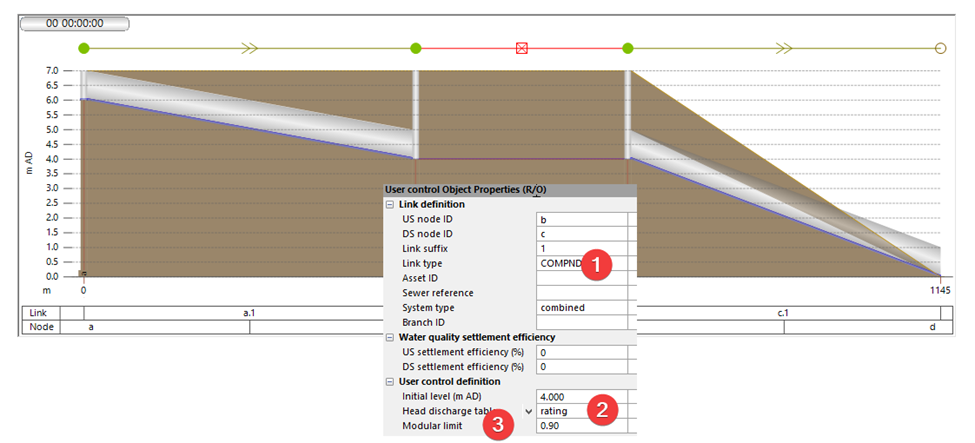

There 4 scenarios of the same network as shown below,

| Scenario | Link Type | H-D table | Modular limit | 
|---|---|---|---| 
| 1 | Compound (m=0.9) | COMPND | rating: 0.9 | 
| 2 | Compound (m=0) | COMPND | rating: 0 | 
| 3 | Vortex (m=0.9) | Vortex | Rating_negative: 0.9 | 
| 4 | Vortex (m=0) | Vortex | Rating_negative: 0 |

Two set of runs with different flow conditions,
•	Positive flow: we feed inflow at the upstream end from 0 to 1 m3/s
•	Negative flow: no inflows, raise the water level on the outfall end from 0 to 7m, then back to 0m


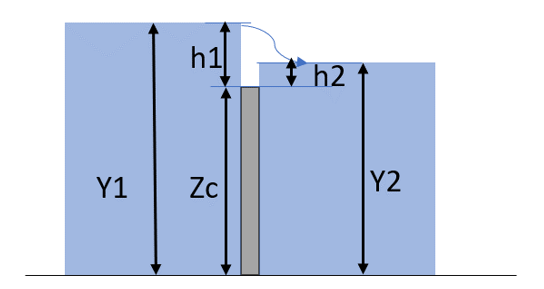

- Weir elevation = 4 #m

variable names:

* flow = us flow
* h1 = us depth
* h2 = ds depth
* flow without drowning factor = us flow/drowning factor
* m = drowning factor

----
* when m=0, head = h1
* when m>0, head = h2-h1

The head discharge table for compound and vortex,
 
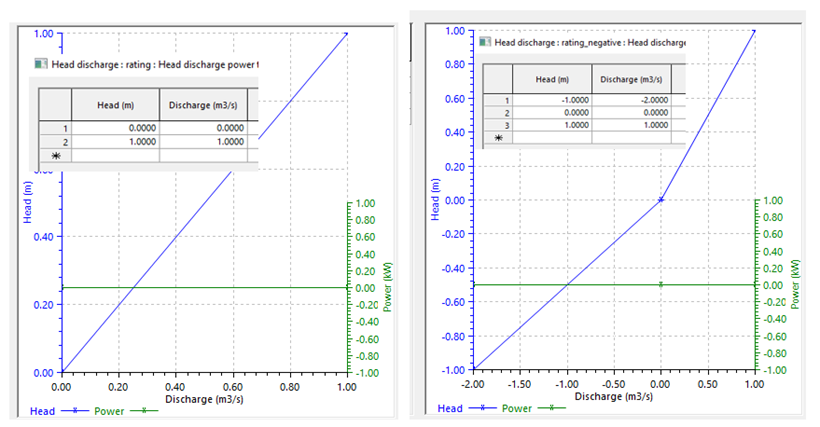

## Positive flow m=0.9

For scenario 1, compound type, m=0.9 with positive flows
- The orange triangles are the simulated points
- The green line is the rating curve
- The blue crosses are calculated as [simulated flow]/[drowning factor]

At low flow conditions, the drowning factor is playing a role, so for the same head (Y axis), simulated flow is lower than the rating curve. And after accounting the drowning factors, blue x points line up with the rating curve. Therefore, we confirmed the drowning equations.



C:\Users\mengm\AppData\Local\Temp\ipykernel_24552\798334102.py:31: RuntimeWarning: invalid value encountered in scalar power
  f = ((1 - h2 / h1) / (1 - m))**0.5


<Axes: title={'center': 'positive'}, xlabel='Discharge (m3/s)'>

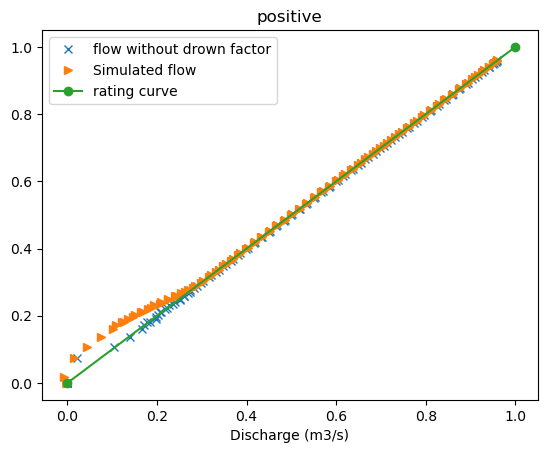

In [24]:
# Scenario 1: positive flow with compound
invert = 4
rc_name = 'rating'
m = 0.9

tab = 'positive'
df = read_excel(excel_path, tab)
df = verify_user_control(invert, rc_name, df, m)
rc = pd.read_excel(excel_path, rc_name)
plot_user_control(df, rc, tab)

# Negative flow compound m=0.9

For scenario 3, with reverse flow and m=0.9 compound type, it should simply mirror the positive flow conditions. As shown in the scatter plot below, after accounting for the drowning factor, the blue x points line up with the rating curves for positive flow, and negative flows with a mirroring rating curve.

<Axes: title={'center': 'negative'}, xlabel='Discharge (m3/s)'>

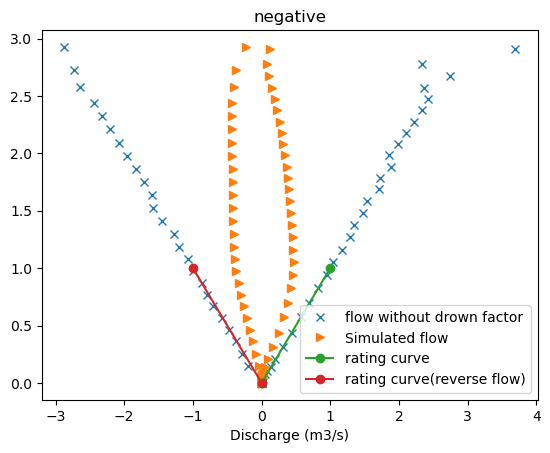

In [25]:
# Scenario 2: negative flow with compound
invert = 4
rc_name = 'rating'
m = 0.9

tab = 'negative'
df = read_excel(excel_path, tab)
df = verify_user_control(invert, rc_name, df, m)
rc = pd.read_excel(excel_path, rc_name)
ax = plot_user_control(df, rc, tab)
rc_neg = rc.copy()
rc_neg['Discharge (m3/s)'] = -1*rc['Discharge (m3/s)']
rc_neg.plot(x='Discharge (m3/s)', y='Head (m)', style='o-', ax=ax, label='rating curve(reverse flow)')

# Negative flow compound m=0
Compound m=0 with negative flows. It simply mirror the same rating curve for negative flow.

<Axes: title={'center': 'compound_m_0'}, xlabel='Discharge (m3/s)'>

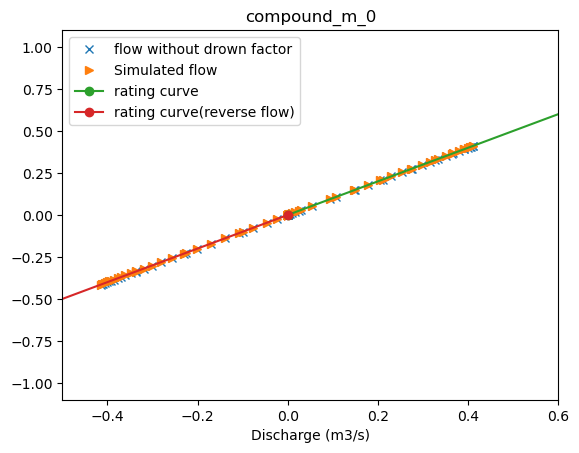

In [32]:
# Scenario 1: vortex m=0
invert = 4
rc_name = 'rating'
m = 0

tab = 'compound_m_0'
df = read_excel(excel_path, tab)
df = verify_user_control(invert, rc_name, df, m, use_diff=True)
rc = pd.read_excel(excel_path, rc_name)
ax = plot_user_control(df, rc, tab)
ax.set_xlim([-0.5, 0.6])
rc_neg['Head (m)'] = -1*rc['Head (m)']
rc_neg.plot(x='Discharge (m3/s)', y='Head (m)', style='o-', ax=ax, label='rating curve(reverse flow)')

## Vortex m=0.9 negtive flow

Since h1 never drops below 0, the negative flow part of the rating curve never got activated.

C:\Users\mengm\AppData\Local\Temp\ipykernel_24552\798334102.py:31: RuntimeWarning: invalid value encountered in scalar power
  f = ((1 - h2 / h1) / (1 - m))**0.5


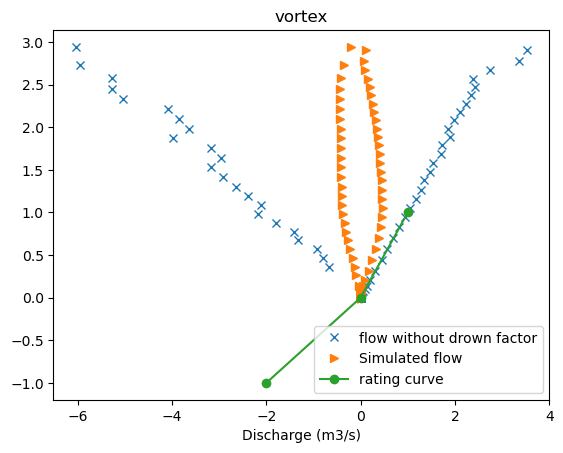

In [27]:
# Scenario 1: vortex
invert = 4
rc_name = 'rating_negative'
m = 0.9

tab = 'vortex'
df = read_excel(excel_path, tab)
df = verify_user_control(invert, rc_name, df, m)
rc = pd.read_excel(excel_path, rc_name)
ax = plot_user_control(df, rc, tab)


# Negative flow vortex m=0
For scenario 4, vortex m=0 with negative flows. With the water depth difference as the head, the simulated flow matches the rating curve on both flow directions.

(-0.5, 0.6)

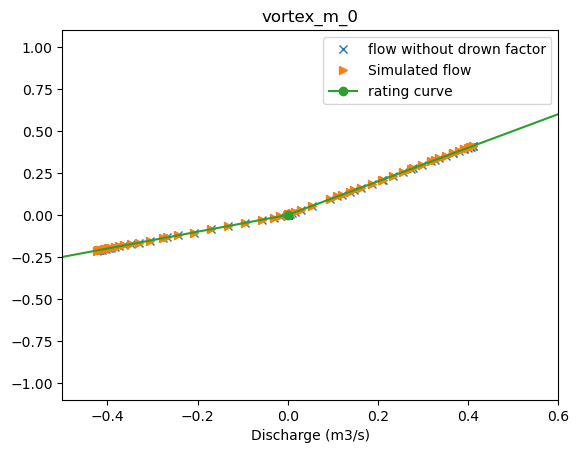

In [33]:
# Scenario 1: vortex m=0
invert = 4
rc_name = 'rating_negative'
m = 0

tab = 'vortex_m_0'
df = read_excel(excel_path, tab)
df = verify_user_control(invert, rc_name, df, m, use_diff=True)
rc = pd.read_excel(excel_path, rc_name)
ax = plot_user_control(df, rc, tab)
ax.set_xlim([-0.5, 0.6])

## Impact of Molular Limit

The updated recommended modular limit is 0.66, the old default value is 0.9 and we recommend using 0.66 if you see oscillations in simulation results.
A lower modular limit value slows down changes in flow. With a lower limit, the system is more likely to enter and remain in a drowning condition, which restricts the flow. This is similar to driving on a long stretch of rough surface that consistently slows you down, compared to a surface that alternates between rough and smooth patches.

From the results below, you can see for m=0.66, it upstream depth (h1) is smoothed comparing with m=0.9.

In [53]:
tab = 'compound_m_09'
df_m09 = read_excel(excel_path, tab)
tab = 'compound_m_066'
df_m066= read_excel(excel_path, tab)
tab = 'compound_m_02'
df_m02= read_excel(excel_path, tab)

In [59]:
invert = 4
rc_name = 'rating'
m = 0.9
df_m09 = verify_user_control(invert, rc_name, df_m09, m, use_diff=False)

In [60]:
invert = 4
rc_name = 'rating'
m = 0.66
df_m066 = verify_user_control(invert, rc_name, df_m066, m, use_diff=False)

In [61]:
invert = 4
rc_name = 'rating'
m = 0.2
df_m02 = verify_user_control(invert, rc_name, df_m02, m, use_diff=False)

<Axes: xlabel='flow'>

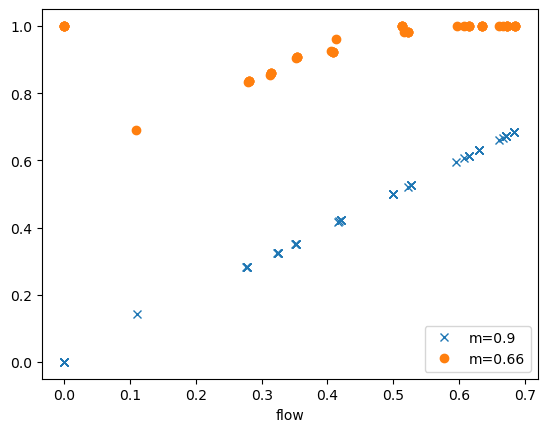

In [62]:
ax = df_m09.plot(x='flow', y='h1', style='x',label='m=0.9')
df_m066.plot(x='flow', y='drownf', style='o', label='m=0.66', ax=ax)

<Axes: xlabel='flow'>

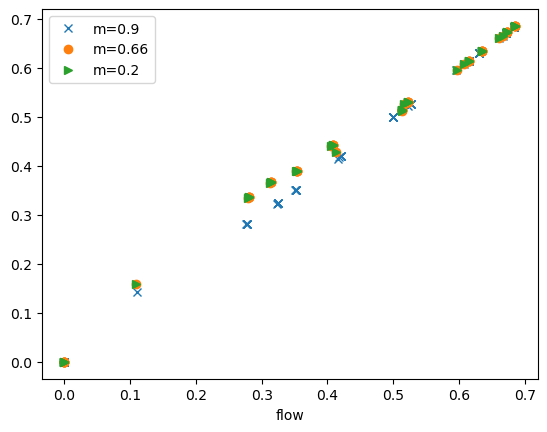

In [63]:
y = 'h1'
ax = df_m09.plot(x='flow', y=y, style='x',label='m=0.9')
df_m066.plot(x='flow', y=y, style='o', label='m=0.66', ax=ax)
df_m02.plot(x='flow', y=y, style='>', label='m=0.2', ax=ax)

Text(0.5, 1.0, 'h1')

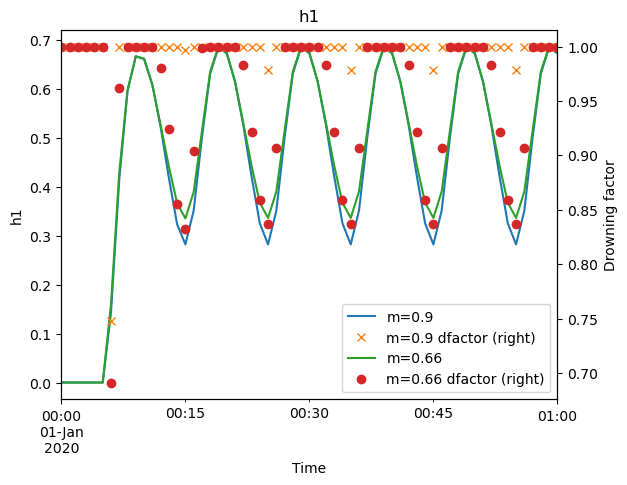

In [49]:
y = 'h1'
df_m09['dt'] = df_m09.index
ax = df_m09.plot(x='dt', y=y, style='-',label='m=0.9')
df_m09.plot(x='dt', y='drownf', style='x',label='m=0.9 dfactor', secondary_y=True, ax=ax)
df_m066['dt'] = df_m066.index
df_m066.plot(x='dt', y=y, style='-', label='m=0.66', ax=ax)
df_m066.plot(x='dt', y='drownf', style='o',label='m=0.66 dfactor', secondary_y=True, ax=ax, ylabel='Drowning factor')
ax.set_xlabel('Time')
ax.set_ylabel(y)
ax.set_title(y)

Text(0.5, 1.0, 'flow')

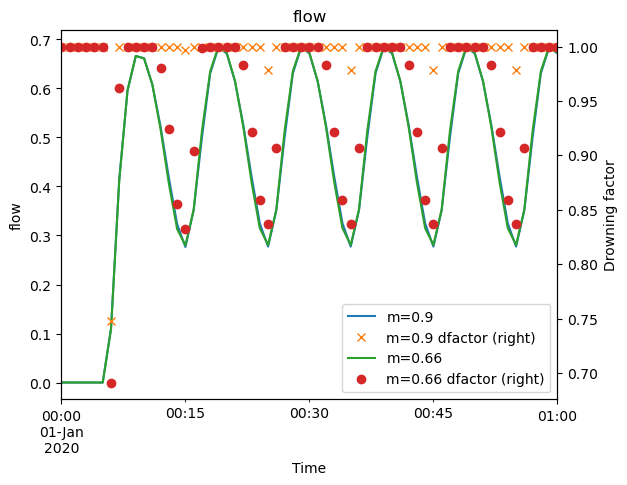

In [50]:
y = 'flow'
df_m09['dt'] = df_m09.index
ax = df_m09.plot(x='dt', y=y, style='-',label='m=0.9')
df_m09.plot(x='dt', y='drownf', style='x',label='m=0.9 dfactor', secondary_y=True, ax=ax)
df_m066['dt'] = df_m066.index
df_m066.plot(x='dt', y=y, style='-', label='m=0.66', ax=ax)
df_m066.plot(x='dt', y='drownf', style='o',label='m=0.66 dfactor', secondary_y=True, ax=ax, ylabel='Drowning factor')
ax.set_xlabel('Time')
ax.set_ylabel(y)
ax.set_title(y)